# Learning How to Machine Learn
When we're investigating a large quantity of potentially malicious samples every day, it can be helpful to automatically triage them to know what to put in front of an analyst. Sometimes we can check external sources like Virus Total, but other times we have sensitive samples we can't submit or hashes are not found. Machine learning is one way to bucket Mach-O files as malicious or benign, or packed or not. 

In this notebook, we'll walk through the steps to collect data and build a malware classification model for Mach-O using static analysis techniques. We'll go through the following steps in an ML process:
1. Data pre-processing
2. Feature selection and engineering
3. Hyper parameter optimization
4. Model training
5. Assessment and validation

# Data pre-processing
In this project we are going to build an ML model using information from Mach-O files. We have have used [Macholibre](https://github.com/aaronst/macholibre) to parse Mach-O files and saved the data as JSON objects in `benign_data`, `malware_data`, and `validation_data`. The parsed files were enriched with Virustotal to obtain the malware family.

We need to load these JSON files as a dataframe. Macholibre outputs nested JSON, which breaks some of the default Pandas `read_json()` functionality. To get around that, we will do some manual processing of the JSON files and load in the data.

<img src="images/json_to_dataframe.png">

In [1]:
import json
import argparse
import os
import pandas as pd
from tqdm import tqdm

def load_json(filename: str) -> str:
    with open(filename, "r") as f:
        data = json.loads(f.read())
    return data


def get_files(path: str) -> list:
    filelist = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            fullpath = os.path.join(root, filename)
            filelist.append(fullpath)
    return filelist


def parse_segment(load_command: object):
    segment = {}
    lname = load_command["name"]
    segment["name"] = lname
    segment[f"segment_{lname}_vmsize"] = load_command["vmsize"]
    segment[f"segment_{lname}_size"] = load_command["size"]
    segment[f"segment_{lname}_initprot"] = load_command["initprot"]
    segment[f"segment_{lname}_maxprot"] = load_command["maxprot"]
    segment[f"segment_{lname}_nsects"] = load_command["nsects"]
    segment[f"segment_{lname}_entropy"] = load_command["entropy"]
    for sect in load_command["sects"]:
        sectname = sect["name"]
        segment[f"segment_{lname}_{sectname}"] = sect
    return segment


def parse_loaddylib(load_command: object, mach: object):
    dylib = {}
    dname = load_command["name"]
    dylib["name"] = dname
    if "imports" in mach["macho"].keys():
        impcount = 0
        for imp in mach["macho"]["imports"]:
            if imp[1] == dname:
                impcount += 1
        dylib[f"dylib_{dname}_imports"] =  impcount
    return dylib


def parse_json(data: object, filename: str):
    mach = {}
    mach["name"] = data["name"]
    mach["size"] = data["size"]
    mach["entropy"] = data["entropy"]
    mach["nlcs"] = data["macho"]["nlcs"]
    mach["slcs"] = data["macho"]["slcs"]
 
    for flag in data["macho"]["flags"]:
        fname = f"flag_{flag}"
        mach[fname] = 1
    if "packed" in filename:
        mach["packed"] = 1
    else:
        mach["packed"] = 0
    if data["malware"] == 1:
        mach["malware"] = 1
    else:
        mach["malware"] = 0
    mach['packed_malware'] = mach["packed"] & mach["malware"]
    try:
        mach['family'] = data['vtscan']['McAfee']['result']
    except:
        try:
            mach['family'] = data['vtscan']['Kaspersky']['result']
        except:
            mach['family'] = "No family"
        
        
    
    num_segments = 0
    num_imports = 0
    for load_command in data["macho"]["lcs"]:
        lc_type = load_command["cmd"]
        if lc_type == "SEGMENT" or lc_type == "SEGMENT_64":
            num_segments += 1
            segment = parse_segment(load_command)
            sname = segment["name"]
            mach[f"{sname}"] = 1
            for k,v in segment.items():
                mach[f"{k}"] = v
        if lc_type == "LOAD_DYLIB":
            num_imports += 1
            dylib = parse_loaddylib(load_command, data)
            dname = dylib["name"]
            mach[f"{dname}"] = 1
            for k,v in dylib.items():
                mach[f"{k}"] = v
    mach["num_segments"] = num_segments
    mach["num_imports"] = num_imports
    return mach


Now we will actually read the `benign_data` and `malware_data` files.

In [2]:
def call_parse(files, malware=0):
    global machos 
    global max_len 
    global keys 

    for file in files:
        toparse = []
        with open(file, "r") as f:
            jsondata = json.loads(f.read())
            if "universal" in jsondata.keys():
                for arch in jsondata["universal"]["machos"]:
                    jsondata["macho"] = arch
                    jsondata['malware'] = malware
                    toparse.append(jsondata)
            else:
                jsondata['malware'] = malware
                toparse.append(jsondata)
        for macho in toparse:
            mach = parse_json(macho, file)
            if not mach:
                print(f"failed {file}")
                continue
            machos.append(mach)
            [keys.append(x) for x in mach.keys()]
            cur_len = len(mach)
            if cur_len > max_len:
                max_len = cur_len

machos = []
max_len = 0
keys = []

files = get_files("benign_data")
call_parse(files)
# Repeat, but with malware. Mark malware in JSON
files = get_files("malware_data")
call_parse(files, malware=1)


In [3]:
df = pd.DataFrame(columns=set(keys))
for col in df.columns:
    if "imports" in col:
        df[col] = df[col].astype('object')

count=0
for mach in tqdm(machos, bar_format="{l_bar}{bar}"):
    for col in df.columns:
        if col in mach.keys():
            if isinstance(mach[col], dict):
                # Instead of storing the dict, store the presence-of
                df.at[count, col] = 1
            else:
                df.at[count, col] = mach[col]
        else:
            if "imports" in col:
                # If the column was not present, call it -1 as an arbitrary "did not exist" value
                df.at[count, col] = -1

    count+=1
df = df.convert_dtypes()

100%|██████████


We will now fill in missing values. Anything missed here will be handled by imputation during the pipeline below.

In [4]:
df = df.fillna(value={'family': "No family"})

In [5]:
for col in df:
    # Get dtype for column
    dt = df[col].dtype 
    # Check if it is a number
    if dt == 'Int64' or dt == 'Float64':
        df[col].fillna(0, inplace=True)
    else:
        df[col].fillna("", inplace=True)

In [7]:
# We can save some time in future runs by writing/reading the dataframe as a CSV
df.to_csv('macho.csv')
#df = pd.read_csv('macho.csv', low_memory=False)

We will answer three questions.
1. Is this file malware?
2. Is this file packed?
3. Is this file packed malware?

We call these y1, y2, and y3.

To answer these questions we'll use the features we imported from the JSON files. We drop the features that provide the answers (packed, name, malware, family, packed_malware). Then we call `train_test_split` to create the training data set with 80% of the entries and the testing split with 20% of the entries.

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
# pd.NA can cause problems with imputation. Convert to np.nan
df = df.replace({pd.NA: np.nan})

X = df.drop(['packed','name','malware','family','packed_malware'], axis=1)

y1 = df['malware'].astype('int')
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.2, random_state = 42)

y2 = df['packed'].astype('int')
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size = 0.2, random_state = 42)

y3 = df['packed_malware'].astype('int')
X_train, X_test, y3_train, y3_test = train_test_split(X, y3, test_size = 0.2, random_state = 42)

# Feature selection and engineering
Next we'll engineer our features. In case any missing values were left, we use [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to fill them. We're going to use a "constant" strategy and use "0" for numeric types and "missing" for string types.

We also want to make our data look normally distributed. We do this with the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

We have some features that are strings and we need to convert those to numbers. We'll use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to create an integer value from the string. For example, we have the "maxprot" characteristic of Load Commands that might look like `["rwx", "r-x", "r--"]`. After encoding, we'll have new columns like `["maxprot_rwx", "maxprot_r-x", "maxprot_r--"]` set to either 0 or 1.

We turn these into a pipeline so that the transformations happen at the time of fitting.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

numeric_features = X_train.select_dtypes('int', 'float').columns
categorical_features = X_train.select_dtypes('string').columns
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0),
    StandardScaler()
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)
col_transformer = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    remainder="passthrough"
)

We started with 2,835 features. Not all of those are going to be useful and including them can reduce the performance of the model. Also, we might overfit, where we'll do really well during training, but not generalize during testing/validation.

To reduce the number of features, we have several options. Which one should we choose? 🤷‍ What we'll need to do is try a bunch and systematically see which one gave us the best results.

[SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) retains the highest _k_ scoring features, using a selectable scoring algorithm. Since we are doing classification, we'll want to use chi2, f_classif, or mutual_info_classif. We could try all and see what works best, but for this notebook we'll just use f_classif. Similarly, we could select several _k_ values and see how they perform, but we'll just use 20.

In [18]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, chi2, f_classif
from datetime import datetime
skb_20 = {}
now = datetime.now()
for count in [1,2,3]:
    selector = SelectKBest(f_classif, k=20)
    y = f"y{count}_train"
    print(f"Fitting {y}")
    pipe = make_pipeline(col_transformer, SelectKBest(f_classif, k=20))
    pipe.fit(X_train, eval(y))
    skb_20[y] = pipe.get_feature_names_out()
print("=== DONE ===")
print(f"  Elapsed time: {datetime.now() - now}")

Fitting y1_train


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   4    8   13   15   32   36   38   52   58   60   67   73   85   92
  102  109  110  116  119  120  148  154  166  170  181  183  207  217
  221  232  243  245  267  271  279  310  327  334  343  354  360  366
  368  374  433  435  452  471  479  493  502  508  509  512  520  539
  541  544  552  557  558  568  584  597  599  600  607  608  628  631
  638  640  655  661  709  721  722  723  734  759  785  793  821  827
  839  854  877  881  885  891  909  927  932  934  935  962  965  966
 1008 1054 1059 1066 1067 1074 1086 1088 1093 1115 1134 1144 1170 1173
 1182 1183 1196 1198 1201 1203 1213 1222 1228 1242 1252 1255 1262 1270
 1272 1275 1283 1296 1298 1319 1326 1339 1350 1370 1414 1428 1443 1448
 1456 1460 1481 1491 1517 1521 1522 1533 1545 1546 1551 1564 1569 1589
 1592 1596 1609 1619 1699 1726 1731 1732 1734 1737 1758 1759 1771 1773
 178

Fitting y2_train


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   4    8   13   15   32   36   38   52   58   60   67   73   85   92
  102  109  110  116  119  120  148  154  166  170  181  183  207  217
  221  232  243  245  267  271  279  310  327  334  343  354  360  366
  368  374  433  435  452  471  479  493  502  508  509  512  520  539
  541  544  552  557  558  568  584  597  599  600  607  608  628  631
  638  640  655  661  709  721  722  723  734  759  785  793  821  827
  839  854  877  881  885  891  909  927  932  934  935  962  965  966
 1008 1054 1059 1066 1067 1074 1086 1088 1093 1115 1134 1144 1170 1173
 1182 1183 1196 1198 1201 1203 1213 1222 1228 1242 1252 1255 1262 1270
 1272 1275 1283 1296 1298 1319 1326 1339 1350 1370 1414 1428 1443 1448
 1456 1460 1481 1491 1517 1521 1522 1533 1545 1546 1551 1564 1569 1589
 1592 1596 1609 1619 1699 1726 1731 1732 1734 1737 1758 1759 1771 1773
 178

Fitting y3_train
=== DONE ===
  Elapsed time: 0:00:05.470653


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   4    8   13   15   32   36   38   52   58   60   67   73   85   92
  102  109  110  116  119  120  148  154  166  170  181  183  207  217
  221  232  243  245  267  271  279  310  327  334  343  354  360  366
  368  374  433  435  452  471  479  493  502  508  509  512  520  539
  541  544  552  557  558  568  584  597  599  600  607  608  628  631
  638  640  655  661  709  721  722  723  734  759  785  793  821  827
  839  854  877  881  885  891  909  927  932  934  935  962  965  966
 1008 1054 1059 1066 1067 1074 1086 1088 1093 1115 1134 1144 1170 1173
 1182 1183 1196 1198 1201 1203 1213 1222 1228 1242 1252 1255 1262 1270
 1272 1275 1283 1296 1298 1319 1326 1339 1350 1370 1414 1428 1443 1448
 1456 1460 1481 1491 1517 1521 1522 1533 1545 1546 1551 1564 1569 1589
 1592 1596 1609 1619 1699 1726 1731 1732 1734 1737 1758 1759 1771 1773
 178

In [19]:
skb_20

{'y1_train': array(['pipeline-1__segment___TEXT___objc_methlist',
        'pipeline-1__/System/Library/Frameworks/Foundation.framework/Versions/C/Foundation',
        'pipeline-1__segment___TEXT_nsects',
        'pipeline-1__segment___DATA_CONST_nsects',
        'pipeline-1__segment___DATA_CONST___const',
        'pipeline-1__segment___DATA_CONST___objc_imageinfo',
        'pipeline-1__segment___TEXT___objc_methname',
        'pipeline-1__segment___DATA___objc_const',
        'pipeline-1__segment___TEXT_size',
        'pipeline-1__/usr/lib/libobjc.A.dylib',
        'pipeline-1__segment___DATA_CONST___got',
        'pipeline-1__segment___DATA_CONST___objc_protolist',
        'pipeline-1__segment___DATA_CONST_size',
        'pipeline-1____DATA_CONST', 'pipeline-1__slcs',
        'pipeline-1__segment___DATA_CONST___objc_classlist',
        'pipeline-2__segment___DATA_CONST_initprot_',
        'pipeline-2__segment___DATA_CONST_initprot_rw-',
        'pipeline-2__segment___DATA_CONST_maxpro

[Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?) is not strictly feature selection, but it reduces dimensionality. We can select _k_ number of components or provide with a float to represent the percentage of variance we want to select. Using 0.95 in this case will drop us down to 258 features.

In [20]:
from sklearn.decomposition import PCA
pca = {}
now = datetime.now()
for count in [1,2,3]:
    selector = PCA(.95)
    y = f"y{count}_train"
    print(f"Fitting {y}")
    pipe = make_pipeline(col_transformer, selector)
    X_train_pca = pipe.fit_transform(X_train)
    n_pcs = pipe.named_steps['pca'].components_.shape[0]
    most_important = [np.abs(pipe.named_steps['pca'].components_[i]).argmax() for i in range(n_pcs)]
    pca[y] = [X_train.columns[most_important[i]] for i in range(n_pcs)]
print("=== DONE ===")
print(f"  Elapsed time: {datetime.now() - now}")

Fitting y1_train
Fitting y2_train
Fitting y3_train
=== DONE ===
  Elapsed time: 0:00:38.916506


[SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) uses an estimator to determine the importance of each feature. We can use a few different estimators (including Random Forest) but we'll use Extra Trees. Using one of these estimators will discard irrelevant features.

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier()
sfm_best = {}
now = datetime.now()
for count in [1,2,3]:
    y = f"y{count}_train"
    print(f"Fitting {y}")
    pipe = make_pipeline(col_transformer, ExtraTreesClassifier())
    pipe.fit(X_train, eval(y))
    pipe.named_steps['extratreesclassifier'].feature_importances_
    clf = pipe.named_steps['extratreesclassifier']
    newpipe = make_pipeline(col_transformer, SelectFromModel(clf, prefit=True, max_features=20))
    newpipe.transform(X_train)    
    sfm_best[y] = newpipe.get_feature_names_out()
print("=== DONE ===")
print(f"  Elapsed time: {datetime.now() - now}")

Fitting y1_train
Fitting y2_train
Fitting y3_train
=== DONE ===
  Elapsed time: 0:00:15.606336


In [22]:
sfm_best

{'y1_train': array(['pipeline-1__segment___TEXT_vmsize',
        'pipeline-1__segment___TEXT___objc_methlist',
        'pipeline-1__/System/Library/Frameworks/AppKit.framework/Versions/C/AppKit',
        'pipeline-1__/System/Library/Frameworks/Foundation.framework/Versions/C/Foundation',
        'pipeline-1__segment___DATA_CONST___const', 'pipeline-1__size',
        'pipeline-1__segment___DATA___objc_const',
        'pipeline-1__segment___TEXT_size',
        'pipeline-1__segment___DATA_CONST___got',
        'pipeline-1__/System/Library/Frameworks/CFNetwork.framework/Versions/A/CFNetwork',
        'pipeline-1__segment___DATA_CONST_size',
        'pipeline-1__flag_NOREEXPORTED_DYLIBS', 'pipeline-1____DATA_CONST',
        'pipeline-1____PAGEZERO',
        'pipeline-1__segment___DATA_CONST___objc_classlist',
        'pipeline-2__segment___DATA_CONST_initprot_',
        'pipeline-2__segment___DATA_CONST_maxprot_',
        'pipeline-2__segment___DATA_CONST_maxprot_rw-',
        'remainder__s

[Sequential Feature Selector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) will either add or remove features based on a cross-validated score. We'll use forward selection since we want 20/2835 features. If we wanted, for example, 20/25 features we'd use backward selection. Note that this is the slowest feature selection method, in part due to the SVC estimator.

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
svm = SVC()
sfs = SequentialFeatureSelector(svm, n_features_to_select=20, n_jobs=-1)
sfs_best = {}
now = datetime.now()
for count in [1,2,3]:
    y = f"y{count}_train"
    print(f"Fitting {y}")
    pipe = make_pipeline(col_transformer, sfs)
    pipe.fit(X_train, eval(y))
    sfs_best[y] = pipe.get_feature_names_out()
print("=== DONE ===")
print(f"  Elapsed time: {datetime.now() - now}")

Fitting y1_train
Fitting y2_train


In [24]:
sfs_best

{'y1_train': array(['pipeline-1__@rpath/ENAttachmentToPDF.framework/Versions/A/ENAttachmentToPDF',
        'pipeline-1__dylib_@rpath/Assets.framework/Assets_imports',
        'pipeline-1__@rpath/TrustUI.framework/TrustUI',
        'pipeline-1__dylib_@rpath/TrustAPI.framework/TrustAPI_imports',
        'pipeline-1__segment___DWARF_vmsize',
        'pipeline-1__dylib_@rpath/libcrypto.dylib_imports',
        'pipeline-1__dylib_@rpath/Signer.framework/Signer_imports',
        'pipeline-1__@loader_path/../../../../../../../libavdevice.58.dylib',
        'pipeline-1__@rpath/libssl.dylib',
        'pipeline-1__@rpath/Sentry.framework/Sentry',
        'pipeline-1__dylib_@rpath/PromiseKit.framework/PromiseKit_imports',
        'pipeline-1__dylib_@rpath/widevine_cdm_secured_ios.framework/widevine_cdm_secured_ios_imports',
        'pipeline-1__@rpath/libplist.3.dylib',
        'pipeline-1__segment___DATA_CONST_nsects',
        'pipeline-1__/System/Library/Frameworks/CoreGraphics.framework/Version

In [25]:
# The selected features were given back to us with prepended text
# We need to remove that text when we access the features in X_train
def strip_items(item):
    stripped_item = item.replace('pipeline-1__','').replace('pipeline-2__','').replace('remainder__','')
    if stripped_item not in df.columns:
        stripped_item = '_'.join(stripped_item.split('_')[:-1])
    return stripped_item

Now that we have our features, we will combine them into a dictionary so we can iterate them during training.

In [26]:
selected_features = {}

selected_features['SelectKBest'] = {}
for key in skb_20.keys():
    selected_features['SelectKBest'][key] = [strip_items(item) for item in skb_20[key].tolist()]

selected_features['ForwardSelection'] = {}
for key in sfs_best.keys():
    selected_features['ForwardSelection'][key] = [strip_items(item) for item in sfs_best[key].tolist()]

selected_features['PCA'] = pca

selected_features['SelectFromModel'] = {}
for key in sfm_best.keys():
    selected_features['SelectFromModel'][key] = [strip_items(item) for item in sfm_best[key].tolist()]

In [27]:
# We see "Unnamed: 0" index values if we've loaded from CSV, so remove them
for k,v in selected_features.items():
    for k2,v2 in selected_features[k].items():
        if 'Unnamed: 0' in v2:
            v2.remove('Unnamed: 0')

In [28]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open('selected_features.json','w') as f:
    f.write(json.dumps(selected_features, cls=NumpyEncoder))

# Hyper Parameter Optimization
[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is used to find the best model hyperparameters, the parameters not learned by the estimator. We pass it the estimator, a parameter grid, how to score the results, and how to refit.

The estimator is the algorithm that we want to optimize hyperparameters for.  
The parameter grid is the hyperparameter names and their values that will be searched. For Random Forest, those hyperparameters are:
* criterion, which specifies the split quality measurement
* max_depth, which determines the maximum depth of the tree
* max_features, which determines the maximum number of features at each split
* n_estimators, which determines the number of trees to create
* min_samples_split, which determines the minimum samples required to split a node

The scoring is one or more methods of scoring the output. We have accuracy, recall, precision, and F1.
* accuracy = (TP + TN) / (TP + FP + TN + FN)
* recall = TP / (TP + FN)
* precision = TP / (TP + FP)
* F1 = 2 * ((precision * recall) / (precision + recall))

The refit will use the entire dataset and the provided scorer to determine the overall winning combination.

By default, we will do 5-fold cross validation. X_train will be split into 5 folds. Four will be used as training and one will be used for testing. At each fold, the test group will change.  
<img src="images/cross_validation.png" alt="5 fold cross validation" width="400"/>

We're going to run these hyperparameter searches across each problem (malware, packed, packed malware) and for each set of selected features. At the end, we'll have models that we can run that are highly tuned to solving each of those problems.

In [30]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, accuracy_score
now = datetime.now()

SCORING = {
    'f1_score': make_scorer(f1_score, average='micro'),
    'precision_score': make_scorer(precision_score, average='micro'),
    'recall_score': make_scorer(recall_score, average='micro'),
    'accuracy_score': make_scorer(accuracy_score)
}
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(4,8),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(100,500,100),
    'min_samples_split': range(2,5)
}

rfc_hyper = {}
for count in [1,2,3]:
    clf = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, scoring=SCORING, refit='f1_score')
    for k in selected_features.keys():
        rfc_y = f"y{count}_{k}"
        y = f'y{count}_train'
        features = list(set(selected_features[k][y]))
        nf = X_train[features].select_dtypes('int', 'float').columns
        cf = X_train[features].select_dtypes('string').columns
        ct = make_column_transformer(
            (numeric_transformer, nf),
            (categorical_transformer, cf),
            remainder="passthrough"
        )
        pipe = make_pipeline(ct, clf)
        pipe.fit(X_train[features], eval(y))
        rfc_hyper[rfc_y] = pipe.named_steps['gridsearchcv'].best_params_
        rfc_hyper[rfc_y]['score'] = pipe.named_steps['gridsearchcv'].best_score_
        rfc_hyper[rfc_y]['features'] = features
    
print("=== DONE ===")
print(f"  Elapsed time: {datetime.now() - now}")

=== DONE ===
  Elapsed time: 0:19:05.234268


In [32]:
model_results = pd.read_json(json.dumps(rfc_hyper), orient="index")
model_results.sort_values('score', ascending=False)

,criterion,max_depth,max_features,min_samples_split,n_estimators,score,features
y2_SelectKBest,gini,4,sqrt,2,100,1.000000,"[segment___LINKEDIT_entropy, segment___TEXT___..."
y2_ForwardSelection,gini,4,sqrt,2,100,1.000000,[@rpath/SyncSupport.framework/Versions/A/SyncS...
y2_SelectFromModel,gini,4,sqrt,2,100,1.000000,"[entropy, segment___LINKEDIT_entropy, segment_..."
y2_PCA,gini,7,sqrt,4,400,0.997863,[@rpath/JNWScrollView.framework/Versions/A/JNW...
y3_SelectFromModel,entropy,7,log2,4,400,0.963307,"[segment___LINKEDIT_entropy, segment___TEXT___..."
y3_ForwardSelection,gini,7,sqrt,3,100,0.960102,[@rpath/SyncSupport.framework/Versions/A/SyncS...
y3_SelectKBest,gini,7,sqrt,4,100,0.950839,"[segment___LINKEDIT_entropy, segment___TEXT___..."
y3_PCA,gini,7,sqrt,2,200,0.944785,[@rpath/JNWScrollView.framework/Versions/A/JNW...
y1_ForwardSelection,entropy,6,sqrt,2,200,0.910226,"[flag_NOREEXPORTED_DYLIBS, @rpath/libplist.3.d..."
y1_SelectFromModel,gini,7,log2,4,200,0.898471,"[flag_NOREEXPORTED_DYLIBS, segment___TEXT_vmsi..."


We loaded the GridSearchCV results into a separate dataframe and sorted by the score. We can see that there are multiple models that will result in perfect predictions to answer y2 - is this file packed? We could pick any of these hyperparameters and feature sets.  
We have pretty good results for y3 - is this file packed malware? The highest score here was 96.33%. When building this model we want to select this combination of hyperparameters.  
The y1 - is this file malware? - performed the worst, getting a score of only 91%. To build a better model, we could try and use more features, obtain more samples/build a larger data set, or try a different algorithm. _Note: With the full feature set, we can get slightly better results at 91.98%_.

# Model Training
Here we'll build the actual models that we'll use to perform predictions. We select the best features and hyperparameters from the previous stage and use them to instantiate the classifier for each question. Then we create predictions using the testing dataset.

In [36]:
rfc_y1 = RandomForestClassifier(criterion=rfc_hyper['y1_ForwardSelection']['criterion'],
                            max_depth=rfc_hyper['y1_ForwardSelection']['max_depth'],
                            min_samples_split=rfc_hyper['y1_ForwardSelection']['min_samples_split'],
                            n_estimators=rfc_hyper['y1_ForwardSelection']['n_estimators'])
nf = X_train[rfc_hyper['y1_ForwardSelection']['features']].select_dtypes('int', 'float').columns
cf = X_train[rfc_hyper['y1_ForwardSelection']['features']].select_dtypes('string').columns
ct = make_column_transformer(
    (numeric_transformer, nf),
    (categorical_transformer, cf),
    remainder="passthrough"
)
pipe_rfc_y1 = make_pipeline(ct, rfc_y1)
pipe_rfc_y1.fit(X_train[rfc_hyper['y1_ForwardSelection']['features']], y1_train)
rfc_y1_pred = pipe_rfc_y1.predict(X_test)

In [43]:
rfc_y2 = RandomForestClassifier(criterion=rfc_hyper['y2_SelectKBest']['criterion'],
                            max_depth=rfc_hyper['y2_SelectKBest']['max_depth'],
                            min_samples_split=rfc_hyper['y2_SelectKBest']['min_samples_split'],
                            n_estimators=rfc_hyper['y2_SelectKBest']['n_estimators'])
nf = X_train[rfc_hyper['y2_SelectKBest']['features']].select_dtypes('int', 'float').columns
cf = X_train[rfc_hyper['y2_SelectKBest']['features']].select_dtypes('string').columns
ct = make_column_transformer(
    (numeric_transformer, nf),
    (categorical_transformer, cf),
    remainder="passthrough"
)
pipe_rfc_y2 = make_pipeline(ct, rfc_y2)
pipe_rfc_y2.fit(X_train[rfc_hyper['y2_SelectKBest']['features']], y2_train)
rfc_y2_pred = pipe_rfc_y2.predict(X_test)

In [44]:
rfc_y3 = RandomForestClassifier(criterion=rfc_hyper['y3_SelectFromModel']['criterion'],
                            max_depth=rfc_hyper['y3_SelectFromModel']['max_depth'],
                            min_samples_split=rfc_hyper['y3_SelectFromModel']['min_samples_split'],
                            n_estimators=rfc_hyper['y3_SelectFromModel']['n_estimators'])
nf = X_train[rfc_hyper['y3_SelectFromModel']['features']].select_dtypes('int', 'float').columns
cf = X_train[rfc_hyper['y3_SelectFromModel']['features']].select_dtypes('string').columns
ct = make_column_transformer(
    (numeric_transformer, nf),
    (categorical_transformer, cf),
    remainder="passthrough"
)
pipe_rfc_y3 = make_pipeline(ct, rfc_y3)
pipe_rfc_y3.fit(X_train[rfc_hyper['y3_SelectFromModel']['features']], y3_train)
rfc_y3_pred = pipe_rfc_y3.predict(X_test)

# Model Evaluation
Finally, we'll evaluate the models. In addition to the numeric values, we can visualize how the models are performing.

A confusion matrix displays the true positives, false positives, true negatives, and false negatives. The proportion of each result contributes to a darker hue. Perfect results will have no color for false negatives/false positives, and a deep color for true negatives/true positives.

A precision-recall curve plots precision on the y-axis and recall on the x-axis. Perfect results are visualized as a line that goes along the top and right of the graph and helps us see where a good balance of the two measures are.

The receiver operator characteristic (ROC) curve displays the false positive rate along the x-axis and the true positive rate along the y-axis. Perfect results are a line that goes along the left and top of the graph. 

Here we define functions to show each graph and then call them.

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def display_cm(y_test, y_pred, pipe, name):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
    plt.savefig(f'{name}_confusion_matrix.png')
    plt.show()

In [38]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
def display_prc(y_test, y_pred, name):
    PrecisionRecallDisplay.from_predictions(y_test, y_pred)
    plt.savefig(f'{name}_precision_recall.png')

In [39]:
from sklearn.metrics import roc_curve, auc
def display_roc(y_test, y_pred, name):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.savefig(f'{name}_roc.png')
    plt.show()

# Malware Results: 
## Accuracy: 0.9131054131054132
## F1: 0.9224904701397714


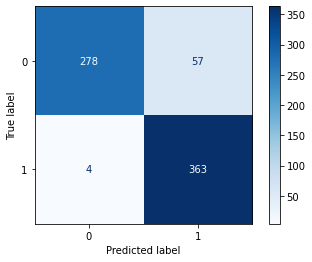

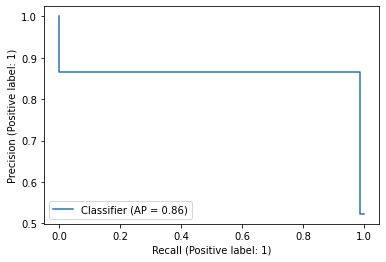

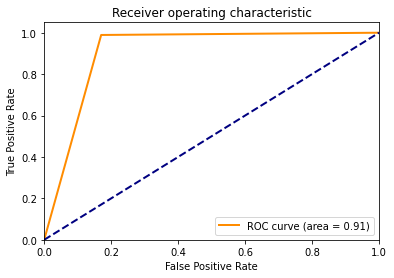

In [51]:
print("# Malware Results: ")
print(f"## Accuracy: {accuracy_score(y1_test, rfc_y1_pred)}")
print(f"## F1: {f1_score(y1_test, rfc_y1_pred)}")
display_cm(y1_test, rfc_y1_pred, pipe, 'rfc_y1')
display_prc(y1_test, rfc_y1_pred, 'rfc_y1')
display_roc(y1_test, rfc_y1_pred, 'rfc_y1')

# Packed Results: 
## Accuracy: 1.0
## F1: 1.0


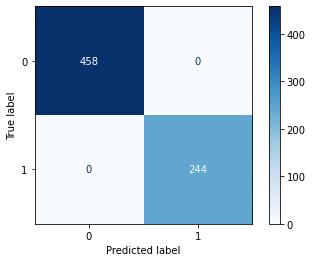

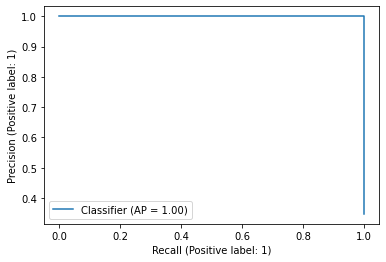

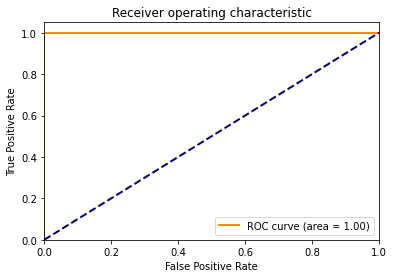

In [52]:
print("# Packed Results: ")
print(f"## Accuracy: {accuracy_score(y2_test, rfc_y2_pred)}")
print(f"## F1: {f1_score(y2_test, rfc_y2_pred)}")
display_cm(y2_test, rfc_y2_pred, pipe, 'rfc_y2')
display_prc(y2_test, rfc_y2_pred, 'rfc_y2')
display_roc(y2_test, rfc_y2_pred, 'rfc_y2')

# Packed Malware Results: 
## Accuracy: 0.9672364672364673
## F1: 0.9396325459317585


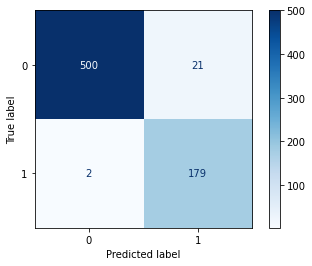

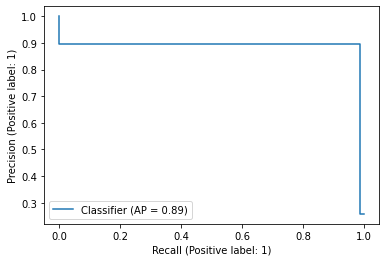

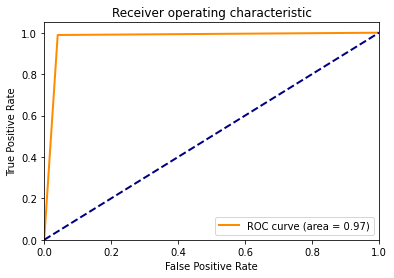

In [53]:
print("# Packed Malware Results: ")
print(f"## Accuracy: {accuracy_score(y3_test, rfc_y3_pred)}")
print(f"## F1: {f1_score(y3_test, rfc_y3_pred)}")
display_cm(y3_test, rfc_y3_pred, pipe, 'rfc_y3')
display_prc(y3_test, rfc_y3_pred, 'rfc_y3')
display_roc(y3_test, rfc_y3_pred, 'rfc_y3')